<a href="https://colab.research.google.com/github/ngurah909/Laptop-recommendation-using-IBM-Granite/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install pandas matplotlib seaborn replicate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # Untuk mengakses variabel lingkungan
import re

# Import Replicate
import replicate

print("Library berhasil diimpor.")

Library berhasil diimpor.


In [5]:
# Cell 2: Pemuatan Data

# Mount Google Drive jika dataset ada di sana
# from google.colab import drive
# drive.mount('/content/drive')

# Path ke dataset Anda. Sesuaikan jika Anda menyimpannya di lokasi berbeda.
# Jika file langsung di root Colab:
file_path = "/content/drive/MyDrive/MyProject/IBM Granite/Dataset/laptops_dataset_final_600.csv"

# Jika di Google Drive setelah di-mount:
# file_path = '/content/drive/MyDrive/path_to_your_dataset/laptops_dataset_final_600.csv'


try:
    df = pd.read_csv(file_path)
    print("Dataset berhasil dimuat.")
    print(f"Jumlah baris dan kolom: {df.shape}")
    print("\n5 baris pertama dataset:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: File tidak ditemukan di {file_path}. Pastikan file sudah diunggah atau path benar.")
    exit() # Keluar jika file tidak ditemukan

Dataset berhasil dimuat.
Jumlah baris dan kolom: (24113, 7)

5 baris pertama dataset:
                                        product_name  overall_rating  \
0  Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...             4.7   
1  Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...             4.7   
2  Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...             4.7   
3  Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...             4.7   
4  Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...             4.7   

  no_ratings no_reviews  rating             title  \
0     15,210        900       5  Perfect product!   
1     15,210        900       5         Fabulous!   
2     15,210        900       5         Fabulous!   
3     15,210        900       4        Delightful   
4     15,210        900       5           Awesome   

                                              review  
0  Loved it, it's my first MacBook that I earned ...  
1  Battery lasted longer than my first relationsh...

In [7]:
# Cell 3: Inspeksi Awal Data (EDA - Eksplorasi Data Awal) - Diperbaiki

print("\nInformasi Dataset:")
df.info()

print("\nStatistik Deskriptif:")
# Statistik deskriptif untuk kolom numerik yang ada
print(df[['overall_rating', 'no_ratings', 'no_reviews', 'rating']].describe())

print("\nJumlah nilai hilang per kolom:")
print(df.isnull().sum())

# Memeriksa nilai unik dalam kolom kategorikal yang ada
print("\nNilai unik untuk kolom 'product_name' (5 teratas):")
print(df['product_name'].value_counts().head())

print("\nNilai unik untuk kolom 'title' (5 teratas):")
print(df['title'].value_counts().head())

print("\nDistribusi 'overall_rating':")
print(df['overall_rating'].value_counts())

print("\nDistribusi 'rating':")
print(df['rating'].value_counts())


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24113 entries, 0 to 24112
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_name    24113 non-null  object 
 1   overall_rating  24113 non-null  float64
 2   no_ratings      24113 non-null  object 
 3   no_reviews      24113 non-null  object 
 4   rating          24113 non-null  int64  
 5   title           24113 non-null  object 
 6   review          24113 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.3+ MB

Statistik Deskriptif:
       overall_rating        rating
count    24113.000000  24113.000000
mean         4.186273      4.214573
std          0.228392      1.184845
min          3.300000      1.000000
25%          4.100000      4.000000
50%          4.200000      5.000000
75%          4.300000      5.000000
max          5.000000      5.000000

Jumlah nilai hilang per kolom:
product_name      0
overal

In [10]:
# Cell 4: Pembersihan dan Pra-pemrosesan Data - Diperbaiki

# 1. Penanganan Nilai Hilang (jika ada)
# Mengisi semua NaN dengan string kosong untuk kemudahan LLM prompt
df = df.fillna('')

# 2. Rekayasa Fitur: Ekstraksi informasi dari 'product_name'
def extract_specs_from_product_name(product_name):
    ram = None
    storage_capacity = None
    storage_type = None
    processor = None
    gpu = None
    os_name = None
    screen_size = None # Less likely to be extracted accurately from this format

    product_name_lower = product_name.lower()

    # Extract RAM (e.g., '8 GB', '16 GB')
    ram_match = re.search(r'(\d+)\s*gb', product_name_lower)
    if ram_match:
        ram = int(ram_match.group(1))

    # Extract Storage (e.g., '256 GB SSD', '512 GB SSD', '1 TB SSD')
    storage_match_gb = re.search(r'(\d+)\s*gb\s*(ssd|hdd)', product_name_lower)
    storage_match_tb = re.search(r'(\d+)\s*tb\s*(ssd|hdd)', product_name_lower)

    if storage_match_gb:
        storage_capacity = int(storage_match_gb.group(1))
        storage_type = storage_match_gb.group(2).upper()
    elif storage_match_tb:
        storage_capacity = int(storage_match_tb.group(1)) * 1024 # Convert TB to GB
        storage_type = storage_match_tb.group(2).upper()
    else:
        # Fallback for common patterns like '512GB SSD' without space or just 'SSD'
        if 'ssd' in product_name_lower:
            storage_type = 'SSD'
            # Try to find capacity if not caught by previous regex
            capacity_patterns = [
                r'(\d+)(?:gb)?\s*ssd', # e.g., '256ssd' or '256gbssd'
                r'(\d+)k\s*ssd', # e.g., '1k ssd'
                r'(\d+)tb\s*ssd' # e.g., '1tb ssd'
            ]
            for pattern in capacity_patterns:
                temp_match = re.search(pattern, product_name_lower)
                if temp_match:
                    val = int(temp_match.group(1))
                    if 'tb' in pattern:
                        storage_capacity = val * 1024
                    elif 'k' in pattern:
                        storage_capacity = val * 1000 # Assuming 1K = 1000GB for some cases
                    else:
                        storage_capacity = val
                    break
        elif 'hdd' in product_name_lower:
            storage_type = 'HDD'
            capacity_patterns = [
                r'(\d+)(?:gb)?\s*hdd',
                r'(\d+)k\s*hdd',
                r'(\d+)tb\s*hdd'
            ]
            for pattern in capacity_patterns:
                temp_match = re.search(pattern, product_name_lower)
                if temp_match:
                    val = int(temp_match.group(1))
                    if 'tb' in pattern:
                        storage_capacity = val * 1024
                    elif 'k' in pattern:
                        storage_capacity = val * 1000
                    else:
                        storage_capacity = val
                    break

    # Extract Processor (simplified for common types, can be expanded)
    if 'intel' in product_name_lower:
        processor_match = re.search(r'intel\s+(core\s+i\d+|celeron|pentium|atom|evo)', product_name_lower)
        if processor_match:
            processor = 'Intel ' + processor_match.group(1).upper()
        elif 'intel' in product_name_lower: # Catch all Intel
            processor = 'Intel'
    elif 'amd' in product_name_lower:
        processor_match = re.search(r'amd\s+(ryzen\s+\d+|athlon)', product_name_lower)
        if processor_match:
            processor = 'AMD ' + processor_match.group(1).upper()
        elif 'amd' in product_name_lower: # Catch all AMD
            processor = 'AMD'
    elif 'apple m' in product_name_lower:
        processor_match = re.search(r'apple\s+(m\d+)', product_name_lower)
        if processor_match:
            processor = 'Apple ' + processor_match.group(1).upper()
        elif 'apple m' in product_name_lower:
            processor = 'Apple M Series'

    # Extract GPU (simplified, often mentioned with specific models like RTX, GTX, Radeon)
    if 'nvidia' in product_name_lower:
        gpu_match = re.search(r'nvidia\s+(geforce\s+rtx\s+\d+|geforce\s+gtx\s+\d+|mx\d+)', product_name_lower)
        if gpu_match:
            gpu = 'NVIDIA ' + gpu_match.group(1).upper()
        elif 'nvidia' in product_name_lower:
            gpu = 'NVIDIA'
    elif 'radeon' in product_name_lower:
        gpu_match = re.search(r'amd\s+(radeon\s+[a-z]+\s*\d+)', product_name_lower)
        if gpu_match:
            gpu = 'AMD ' + gpu_match.group(1).upper()
        elif 'amd radeon' in product_name_lower:
            gpu = 'AMD Radeon'
    elif 'intel iris xe' in product_name_lower:
        gpu = 'Intel Iris Xe'
    elif 'intel uhd' in product_name_lower:
        gpu = 'Intel UHD Graphics'
    elif 'apple graphics' in product_name_lower:
        gpu = 'Apple Graphics'


    # Extract Operating System
    os_match = re.search(r'(mac os|windows\s+\d+\s+home|windows\s+\d+\s+pro|windows|dos|chrome os|linux)', product_name_lower)
    if os_match:
        os_name = os_match.group(1).replace('mac os', 'macOS').title()
        # Standardize Windows naming
        if 'windows' in os_name.lower():
             os_name = os_name.replace(' Home', ' Home').replace(' Pro', ' Pro')

    # Extract Screen Size (e.g., '15.6"', '14 inch')
    screen_size_match = re.search(r'(\d+(\.\d+)?)\s*(inch|\")', product_name_lower)
    if screen_size_match:
        screen_size = float(screen_size_match.group(1))

    return ram, storage_capacity, storage_type, processor, gpu, os_name, screen_size

# Apply extraction function
df[['RAM_GB', 'Storage_Capacity_GB', 'Storage_Type', 'Processor_Name', 'GPU_Name', 'OS_Name', 'Screen_Size_Inches']] = \
    df['product_name'].apply(lambda x: pd.Series(extract_specs_from_product_name(x)))


# 3. Membuat kolom gabungan 'Features_Text' untuk prompt LLM
# Menggunakan kolom baru yang diekstrak dan juga kolom asli yang relevan.
df['Features_Text'] = df.apply(lambda row: f"Product Name: {row['product_name']}. "
                                             f"Extracted Specs: RAM: {row['RAM_GB'] if pd.notna(row['RAM_GB']) else 'N/A'}GB. "
                                             f"Storage: {row['Storage_Capacity_GB'] if pd.notna(row['Storage_Capacity_GB']) else 'N/A'}GB {row['Storage_Type'] if pd.notna(row['Storage_Type']) else 'N/A'}. "
                                             f"Processor: {row['Processor_Name'] if pd.notna(row['Processor_Name']) else 'N/A'}. "
                                             f"GPU: {row['GPU_Name'] if pd.notna(row['GPU_Name']) else 'N/A'}. "
                                             f"Operating System: {row['OS_Name'] if pd.notna(row['OS_Name']) else 'N/A'}. "
                                             f"Screen Size: {row['Screen_Size_Inches'] if pd.notna(row['Screen_Size_Inches']) else 'N/A'} inches. "
                                             f"Overall Rating: {row['overall_rating']}. "
                                             f"Number of Ratings: {row['no_ratings']}. "
                                             f"Number of Reviews: {row['no_reviews']}. "
                                             f"Review Title: {row['title']}. "
                                             f"Review Text: {row['review']}.",
                               axis=1)


print("\nDataset setelah pra-pemrosesan dan rekayasa fitur:")
print(df[['product_name', 'RAM_GB', 'Storage_Capacity_GB', 'Storage_Type', 'Processor_Name', 'GPU_Name', 'OS_Name', 'Screen_Size_Inches', 'Features_Text']].head())

print("\nDistribusi RAM_GB yang diekstrak:")
print(df['RAM_GB'].value_counts(dropna=False))
print("\nDistribusi Storage_Type yang diekstrak:")
print(df['Storage_Type'].value_counts(dropna=False))
print("\nDistribusi Processor_Name yang diekstrak:")
print(df['Processor_Name'].value_counts(dropna=False))
print("\nDistribusi GPU_Name yang diekstrak:")
print(df['GPU_Name'].value_counts(dropna=False))
print("\nDistribusi OS_Name yang diekstrak:")
print(df['OS_Name'].value_counts(dropna=False))
print("\nDistribusi Screen_Size_Inches yang diekstrak:")
print(df['Screen_Size_Inches'].value_counts(dropna=False))


Dataset setelah pra-pemrosesan dan rekayasa fitur:
                                        product_name  RAM_GB  \
0  Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...     8.0   
1  Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...     8.0   
2  Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...     8.0   
3  Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...     8.0   
4  Apple MacBook AIR Apple M2 - (8 GB/256 GB SSD/...     8.0   

   Storage_Capacity_GB Storage_Type Processor_Name  GPU_Name OS_Name  \
0                256.0          SSD       Apple M2       NaN   Macos   
1                256.0          SSD       Apple M2       NaN   Macos   
2                256.0          SSD       Apple M2       NaN   Macos   
3                256.0          SSD       Apple M2       NaN   Macos   
4                256.0          SSD       Apple M2       NaN   Macos   

   Screen_Size_Inches                                      Features_Text  
0                 NaN  Product Name: Apple MacBook AIR 

In [12]:
# Cell 5: Konfigurasi dan Fungsi untuk IBM Granite (via Replicate)
from google.colab import userdata

# Setel kunci API Replicate Anda
# Sangat disarankan untuk menggunakan variabel lingkungan daripada menuliskannya langsung di kode.
# Caranya: Buka menu "Runtime" -> "Change runtime type", lalu di bagian "Environment variables" tambahkan REPLICATE_API_TOKEN.
# Atau Anda bisa langsung set di cell ini (JIKA HANYA UNTUK PENGUJIAN LOKAL DAN TIDAK AKAN DIBAGIKAN KE REPOSITORY PUBLIK):
# os.environ["REPLICATE_API_TOKEN"] = "r8_YOUR_REPLICATE_API_TOKEN_HERE" # Ganti dengan kunci API Anda
os.environ["REPLICATE_API_TOKEN"] = userdata.get('REPLICATE_API_TOKEN')

# Pastikan token sudah diatur
if "REPLICATE_API_TOKEN" not in os.environ:
    print("REPLICATE_API_TOKEN belum disetel sebagai variabel lingkungan.")
    print("Silakan set di menu Google Colab: Runtime -> Change runtime type -> Environment variables, lalu restart runtime.")
    # Jika Anda ingin menghentikan eksekusi jika token tidak ada:
    # exit()

# Ganti dengan ID model IBM Granite yang Anda temukan di Replicate.
# Contoh: 'ibm/granite-13b-instruct' atau model lain yang tersedia.
# Cek https://replicate.com/models untuk menemukan model IBM Granite yang spesifik.
# Jika IBM Granite tidak tersedia atau bermasalah, Anda bisa mencoba model lain yang kuat
# yang tersedia di Replicate (misal: 'meta/llama-2-70b-chat' atau 'mistralai/mistral-7b-instruct-v0.2')
# Penting: Sesuaikan dengan model yang benar-benar ingin Anda gunakan.
GRANITE_MODEL_ID = "ibm-granite/granite-3.3-8b-instruct" # Placeholder, GANTI DENGAN IBM GRANITE ID yang sesuai

def get_granite_response(prompt_text, max_new_tokens=50, temperature=0.1):
    """
    Mengirim prompt ke model IBM Granite (atau model LLM yang dipilih) melalui Replicate API.
    """
    try:
        # Periksa apakah API token sudah disetel
        if "REPLICATE_API_TOKEN" not in os.environ or not os.environ["REPLICATE_API_TOKEN"]:
            raise ValueError("REPLICATE_API_TOKEN tidak disetel atau kosong.")

        # Panggil API Replicate
        # Gunakan 'model' string untuk Replicate, bukan objek
        output = replicate.run(
            GRANITE_MODEL_ID,
            input={"prompt": prompt_text,
                   "max_new_tokens": max_new_tokens,
                   "temperature": temperature}
        )
        # Output dari Replicate bisa berupa generator, jadi kita gabungkan
        response_text = "".join(output)
        return response_text.strip()
    except Exception as e:
        print(f"Error saat memanggil Replicate API: {e}")
        return "ERROR_RESPONSE"

print("Fungsi 'get_granite_response' telah didefinisikan.")
print(f"Model LLM yang akan digunakan: {GRANITE_MODEL_ID}")

Fungsi 'get_granite_response' telah didefinisikan.
Model LLM yang akan digunakan: ibm-granite/granite-3.3-8b-instruct


In [28]:
# Cell 6: Klasifikasi Laptop Menggunakan IBM Granite (Final - Mengklasifikasikan dan Meringkas Semua Data Unik)

# Definisikan kategori target yang kita inginkan
categories = ["Gaming", "Produktivitas", "Portabel", "Anggaran", "Lainnya"] # Tambahkan 'Lainnya' untuk fallback

# Fungsi untuk mengklasifikasikan satu laptop menggunakan Granite
def classify_laptop_with_granite(product_name, ram_gb, storage_capacity_gb, storage_type, processor_name, gpu_name, os_name, screen_size_inches, avg_overall_rating, total_no_reviews, all_reviews_text):

    # Prompt yang lebih detail dengan kriteria untuk setiap kategori
    prompt_criteria = (
        "Anda adalah seorang ahli klasifikasi laptop. Klasifikasikan laptop berikut ke dalam salah satu dari lima kategori tunggal yang paling akurat:\n"
        "- **Gaming**: Ditujukan untuk pengalaman bermain game yang intensif. Ciri-ciri utama: memiliki **GPU diskrit kuat** (misal: NVIDIA GeForce RTX/GTX seri tinggi seperti 30-series ke atas, AMD Radeon RX seri tinggi), **RAM minimal 16GB** atau lebih, prosesor performa tinggi (misal: Intel Core i5/i7/i9 seri H/HX, AMD Ryzen 5/7/9 seri H/HS/HX).\n"
        "- **Produktivitas**: Dirancang untuk pekerjaan kantor, multitasking, pengembangan perangkat lunak, atau kebutuhan kreatif (non-gaming berat). Ciri-ciri utama: **RAM 8GB hingga 16GB (atau lebih)**, **penyimpanan SSD** (umumnya 256GB ke atas), prosesor efisien dan bertenaga (misal: Intel Core i3/i5/i7/i9 U-series atau seri P, AMD Ryzen 3/5/7 U-series, atau Apple M-series). Biasanya menggunakan **grafis terintegrasi** atau GPU diskrit tingkat pemula. Fokus pada keseimbangan performa dan efisiensi.\n"
        "- **Portabel**: Prioritas utama adalah mobilitas, ringan, dan daya tahan baterai yang lama. Ciri-ciri utama: **layar umumnya 14 inci atau lebih kecil**, bobot sangat ringan (biasanya di bawah 1.5 kg, jika data bobot tersedia), desain tipis. Spesifikasi prosesor biasanya efisien daya (U-series, Apple M-series). Umumnya menggunakan **grafis terintegrasi**.\n"
        "- **Anggaran**: Pilihan hemat biaya untuk tugas-tugas dasar seperti Browse, email, atau penggunaan aplikasi ringan. Ciri-ciri utama: **RAM 4GB atau 8GB**, mungkin masih menggunakan **HDD** atau SSD kapasitas kecil (128-256GB), prosesor tingkat pemula (misal: Intel Celeron, Pentium, atau AMD Athlon/Ryzen 3 seri rendah). Grafis terintegrasi. Performanya terbatas.\n"
        "- **Lainnya**: Untuk laptop yang tidak secara jelas masuk ke dalam salah satu kategori di atas berdasarkan spesifikasi yang diberikan.\n\n"
    )

    # Buat string fitur yang lebih ringkas dan fokus pada spesifikasi kunci
    features_for_prompt = (
        f"Product Name: {product_name}. "
        f"Specs: RAM: {ram_gb if pd.notna(ram_gb) else 'N/A'}GB. "
        f"Storage: {storage_capacity_gb if pd.notna(storage_capacity_gb) else 'N/A'}GB {storage_type if pd.notna(storage_type) else 'N/A'}. "
        f"Processor: {processor_name if pd.notna(processor_name) else 'N/A'}. "
        f"GPU: {gpu_name if pd.notna(gpu_name) else 'N/A'}. "
        f"OS: {os_name if pd.notna(os_name) else 'N/A'}. "
        f"Screen Size: {screen_size_inches if pd.notna(screen_size_inches) else 'N/A'} inches. "
        f"Average Overall Rating: {avg_overall_rating:.1f} (dari {total_no_reviews} reviews)."
    )

    prompt = f"{prompt_criteria}\nKlasifikasikan laptop berikut:\n{features_for_prompt}\nKategori:"

    response = get_granite_response(prompt, max_new_tokens=10, temperature=0.1)

    # Post-pemrosesan respons
    for cat in categories:
        if cat.lower() in response.lower():
            return cat

    if "ERROR_RESPONSE" in response:
        return "ERROR_CLASSIFICATION"
    return "Lainnya" # Jika Granite tidak mengembalikan kategori yang dikenali


# --- BAGIAN AGREGRASI DATA UNTUK PRODUK UNIK ---
print("Membuat DataFrame produk unik dan mengagregasi fitur...")

# Pastikan kolom rating_numeric ada sebelum agregasi
df['rating_numeric'] = pd.to_numeric(df['rating'], errors='coerce')
df['no_ratings_numeric'] = pd.to_numeric(df['no_ratings'].str.replace(',', ''), errors='coerce')
df['no_reviews_numeric'] = pd.to_numeric(df['no_reviews'].str.replace(',', ''), errors='coerce')


# Agregasi data per product_name
df_unique_products = df.groupby('product_name').agg(
    avg_overall_rating=('overall_rating', 'mean'),
    avg_individual_rating=('rating_numeric', 'mean'),
    total_no_ratings=('no_ratings_numeric', 'first'),
    total_no_reviews=('no_reviews_numeric', 'first'),
    all_reviews_text=('review', lambda x: " ".join(x.dropna().astype(str).unique())), # Gabungkan review unik
    all_titles_text=('title', lambda x: " ".join(x.dropna().astype(str).unique())),   # Gabungkan judul review unik
    RAM_GB=('RAM_GB', lambda x: x.mode()[0] if not x.mode().empty else np.nan),
    Storage_Capacity_GB=('Storage_Capacity_GB', lambda x: x.mode()[0] if not x.mode().empty else np.nan),
    Storage_Type=('Storage_Type', lambda x: x.mode()[0] if not x.mode().empty else ''),
    Processor_Name=('Processor_Name', lambda x: x.mode()[0] if not x.mode().empty else ''),
    GPU_Name=('GPU_Name', lambda x: x.mode()[0] if not x.mode().empty else ''),
    OS_Name=('OS_Name', lambda x: x.mode()[0] if not x.mode().empty else ''),
    Screen_Size_Inches=('Screen_Size_Inches', lambda x: x.mode()[0] if not x.mode().empty else np.nan)
).reset_index()

# Membuat Features_Text_Display yang baru untuk produk unik
df_unique_products['Features_Text_Display'] = df_unique_products.apply(
    lambda row: f"Product Name: {row['product_name']}. "
                  f"Specs: RAM: {row['RAM_GB'] if pd.notna(row['RAM_GB']) else 'N/A'}GB. "
                  f"Storage: {row['Storage_Capacity_GB'] if pd.notna(row['Storage_Capacity_GB']) else 'N/A'}GB {row['Storage_Type'] if pd.notna(row['Storage_Type']) else 'N/A'}. "
                  f"Processor: {row['Processor_Name'] if pd.notna(row['Processor_Name']) else 'N/A'}. "
                  f"GPU: {row['GPU_Name'] if pd.notna(row['GPU_Name']) else 'N/A'}. "
                  f"OS: {row['OS_Name'] if pd.notna(row['OS_Name']) else 'N/A'}. "
                  f"Screen Size: {row['Screen_Size_Inches'] if pd.notna(row['Screen_Size_Inches']) else 'N/A'} inches. "
                  f"Average Overall Rating: {row['avg_overall_rating']:.1f}. "
                  f"Total Reviews Count: {row['total_no_reviews']}. ",
    axis=1
)


print(f"Jumlah produk unik yang akan diklasifikasikan: {len(df_unique_products)}")
print("\nContoh Features_Text_Display untuk produk pertama:")
print(df_unique_products['Features_Text_Display'].iloc[0])


# --- BAGIAN FINAL: Meringkas Review untuk SEMUA Produk Unik ---
print("\nMemulai proses meringkas review untuk SEMUA produk unik menggunakan IBM Granite...")
print("Peringatan: Proses ini akan memakan waktu lama dan mungkin menghabiskan kuota API Anda.")
df_unique_products['Summarized_Review'] = '' # Inisialisasi kolom

# Mengatur num_unique_samples_to_summarize ke seluruh dataset
num_unique_samples_to_summarize = len(df_unique_products)

for i in range(min(num_unique_samples_to_summarize, len(df_unique_products))):
    row = df_unique_products.loc[i]
    combined_reviews = row['all_reviews_text']

    if len(combined_reviews.strip()) > 50: # Hanya ringkas jika ada cukup teks
        prompt_summary = (f"Ringkas review pengguna berikut tentang laptop:\n"
                          f"'{combined_reviews[:2000]}'\n" # Batasi input review ke 2000 karakter
                          f"Ringkasan singkat (maksimal 3 kalimat) dari sentimen dan poin utama review:")

        summary = get_granite_response(prompt_summary, max_new_tokens=150, temperature=0.5)
        df_unique_products.loc[i, 'Summarized_Review'] = summary
        print(f" - Review untuk '{row['product_name']}' diringkas. ({i+1}/{len(df_unique_products)})")
    else:
        df_unique_products.loc[i, 'Summarized_Review'] = "Tidak ada review yang cukup untuk diringkas."
        print(f" - Tidak cukup review untuk meringkas '{row['product_name']}'. ({i+1}/{len(df_unique_products)})")

print("\nProses meringkas review selesai untuk SEMUA produk unik.")


# --- BAGIAN FINAL: Klasifikasi SEMUA Produk Unik DENGAN IBM GRANITE ---
print("\nMemulai klasifikasi SEMUA produk unik menggunakan IBM Granite...")
print("Peringatan: Proses ini akan memakan waktu lama dan mungkin menghabiskan kuota API Anda.")

# Mengatur num_unique_samples_to_classify ke seluruh dataset
num_unique_samples_to_classify = len(df_unique_products)

df_unique_products['Category'] = None # Inisialisasi kolom kategori (jika belum ada/perlu direset)

# Loop untuk mengklasifikasikan semua produk unik
for i in range(min(num_unique_samples_to_classify, len(df_unique_products))):
    row = df_unique_products.loc[i]
    classified_category = classify_laptop_with_granite(
        product_name=row['product_name'],
        ram_gb=row['RAM_GB'],
        storage_capacity_gb=row['Storage_Capacity_GB'],
        storage_type=row['Storage_Type'],
        processor_name=row['Processor_Name'],
        gpu_name=row['GPU_Name'],
        os_name=row['OS_Name'],
        screen_size_inches=row['Screen_Size_Inches'],
        avg_overall_rating=row['avg_overall_rating'],
        total_no_reviews=row['total_no_reviews'],
        all_reviews_text=row['all_reviews_text']
    )
    df_unique_products.loc[i, 'Category'] = classified_category
    print(f"Produk '{row['product_name']}' diklasifikasikan sebagai: {classified_category} ({i+1}/{len(df_unique_products)})")

print("\nKlasifikasi selesai untuk SEMUA produk unik.")
print("\nDistribusi kategori hasil klasifikasi Granite (untuk SEMUA produk unik yang diklasifikasikan):")
print(df_unique_products['Category'].value_counts(dropna=False))

# df_classified akan menjadi DataFrame produk unik yang sudah diklasifikasikan dan diringkas
df_classified = df_unique_products[df_unique_products['Category'].notna() & (df_unique_products['Category'] != 'ERROR_CLASSIFICATION')].copy()
print(f"\nJumlah produk unik yang berhasil diklasifikasikan dan diringkas: {len(df_classified)}")

Membuat DataFrame produk unik dan mengagregasi fitur...
Jumlah produk unik yang akan diklasifikasikan: 365

Contoh Features_Text_Display untuk produk pertama:
Product Name: ASUS AMD Ryzen 5 Quad Core - (16 GB/512 GB SSD/Windows 11 Home.... Specs: RAM: 16.0GB. Storage: 512.0GB SSD. Processor: AMD RYZEN 5. GPU: . OS: Windows 11 Home. Screen Size: N/A inches. Average Overall Rating: 4.8. Total Reviews Count: 1. 

Memulai proses meringkas review untuk SEMUA produk unik menggunakan IBM Granite...
Peringatan: Proses ini akan memakan waktu lama dan mungkin menghabiskan kuota API Anda.
 - Tidak cukup review untuk meringkas 'ASUS AMD Ryzen 5 Quad Core - (16 GB/512 GB SSD/Windows 11 Home...'. (1/365)
 - Review untuk 'ASUS AMD Ryzen 5 Quad Core - (8 GB/512 GB SSD/Windows 11 Home)...' diringkas. (2/365)
 - Review untuk 'ASUS Chromebook Intel Celeron Dual Core N3350 - (4 GB/32 GB EM...' diringkas. (3/365)
 - Review untuk 'ASUS Chromebook Intel Celeron Dual Core N4500 - (4 GB/128 GB E...' diringkas.

In [29]:
# Cell baru: Menyimpan DataFrame yang dihasilkan

df_classified.to_csv('classified_laptops_data.csv', index=False)
print("DataFrame 'df_classified' berhasil disimpan ke 'classified_laptops_data.csv'")
print("Anda dapat menemukan file ini di panel 'Files' di sebelah kiri Google Colab Anda.")

DataFrame 'df_classified' berhasil disimpan ke 'classified_laptops_data.csv'
Anda dapat menemukan file ini di panel 'Files' di sebelah kiri Google Colab Anda.



Visualisasi berdasarkan kategori yang diklasifikasikan oleh IBM Granite (Produk Unik):

Hubungan antara Kategori dan Rata-rata Overall Rating:


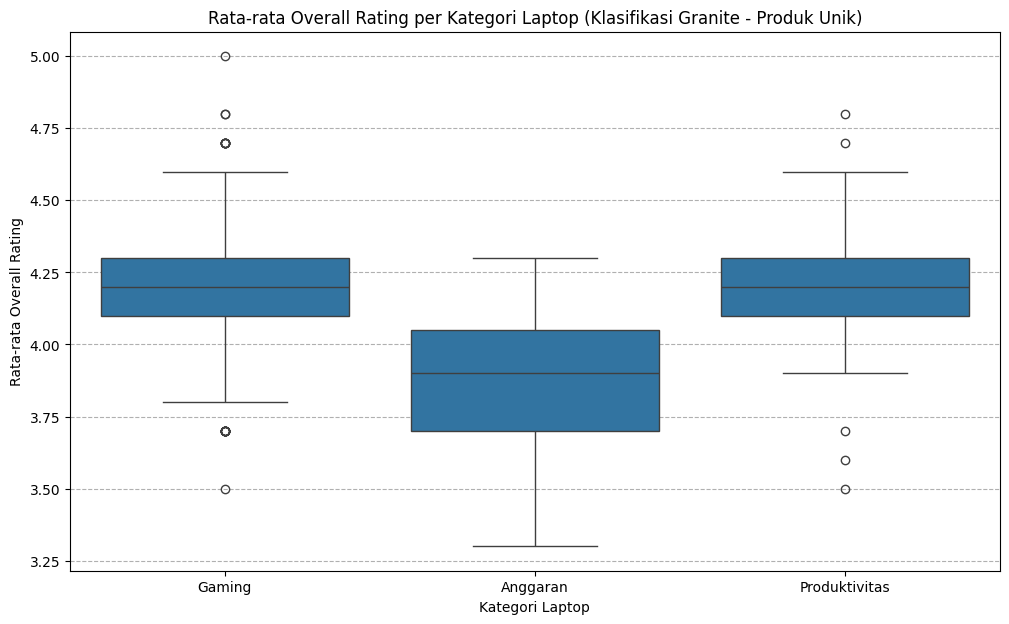


Distribusi Rata-rata Jumlah Ratings per Kategori:


/tmp/ipython-input-30-3863314000.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='total_no_ratings', data=df_classified, palette='viridis', estimator=np.mean)


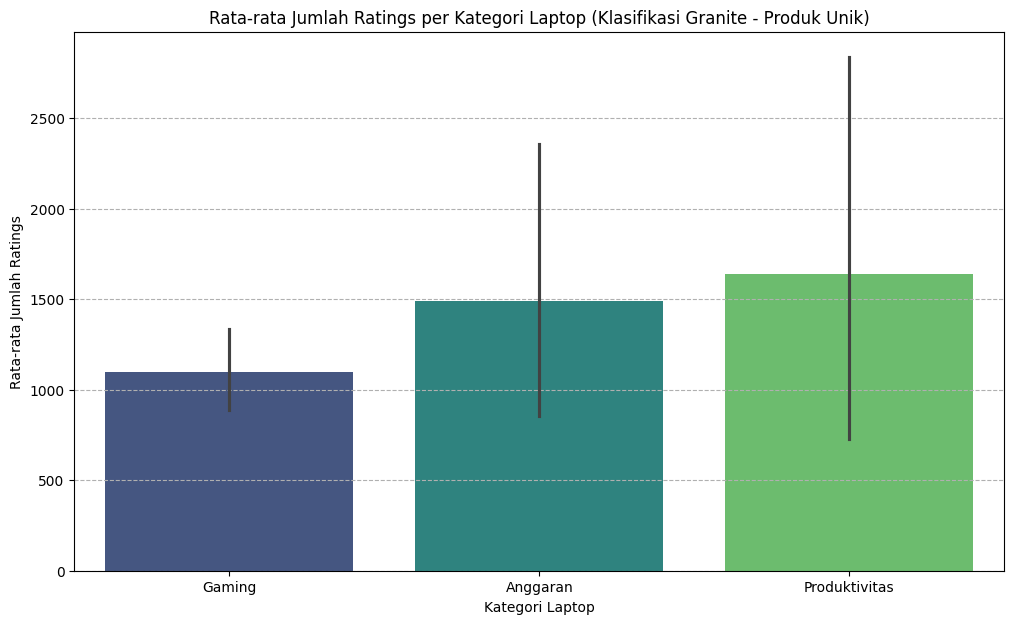


Distribusi RAM (GB) per Kategori (Klasifikasi Granite - Produk Unik):


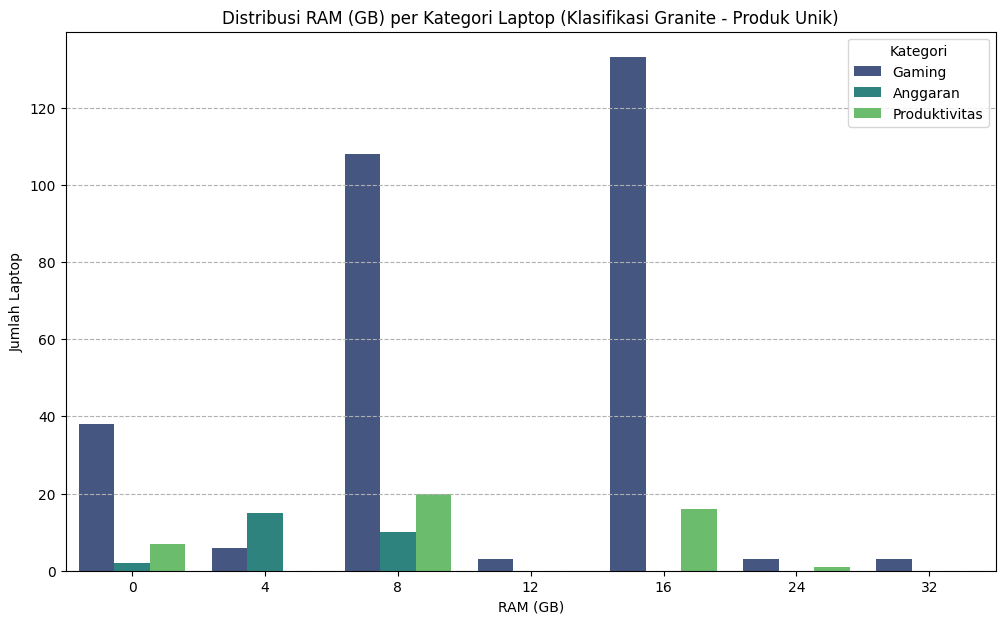


Distribusi Tipe Penyimpanan per Kategori (Klasifikasi Granite - Produk Unik):


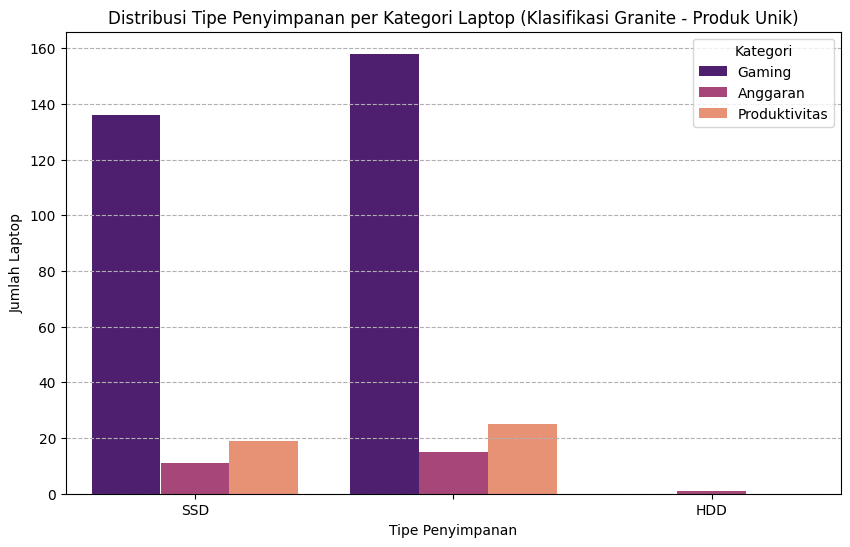


Distribusi Merek Prosesor per Kategori (Klasifikasi Granite - Produk Unik):


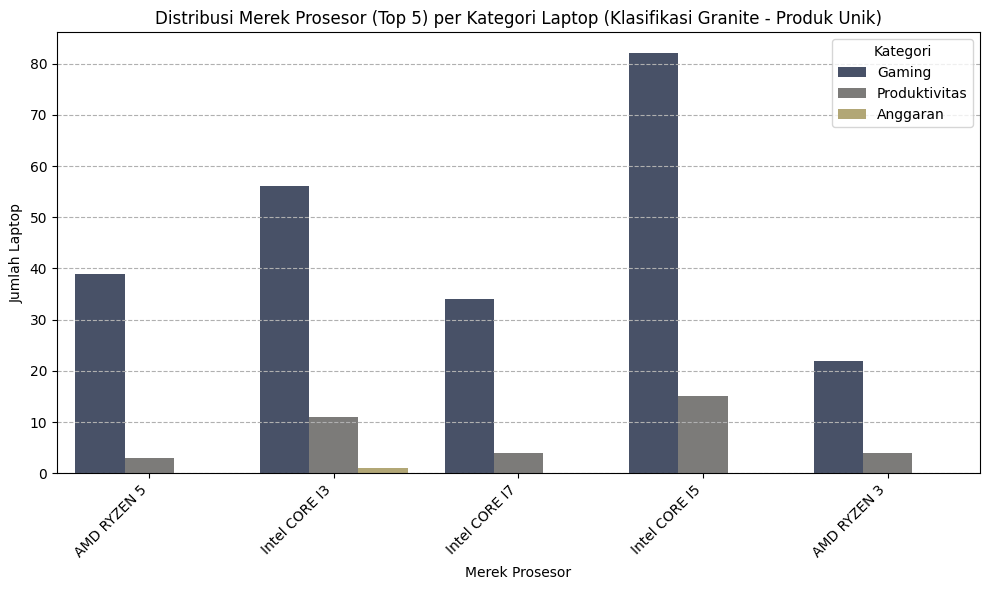

In [30]:
# Cell 7: Eksplorasi Data Berdasarkan Kategori Hasil Klasifikasi Granite (Menggunakan df_classified yang baru)

# Pastikan df_classified memiliki data dari produk unik yang sudah diklasifikasikan
if not df_classified.empty:
    print("\nVisualisasi berdasarkan kategori yang diklasifikasikan oleh IBM Granite (Produk Unik):")

    # Pastikan kolom numerik sudah dalam format yang benar dari agregasi di Cell 6
    # 'avg_overall_rating' sudah numerik
    # 'total_no_ratings' dan 'total_no_reviews' juga sudah numerik

    print("\nHubungan antara Kategori dan Rata-rata Overall Rating:")
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='Category', y='avg_overall_rating', data=df_classified)
    plt.title('Rata-rata Overall Rating per Kategori Laptop (Klasifikasi Granite - Produk Unik)')
    plt.xlabel('Kategori Laptop')
    plt.ylabel('Rata-rata Overall Rating')
    plt.grid(axis='y', linestyle='--')
    plt.show()

    print("\nDistribusi Rata-rata Jumlah Ratings per Kategori:")
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Category', y='total_no_ratings', data=df_classified, palette='viridis', estimator=np.mean)
    plt.title('Rata-rata Jumlah Ratings per Kategori Laptop (Klasifikasi Granite - Produk Unik)')
    plt.xlabel('Kategori Laptop')
    plt.ylabel('Rata-rata Jumlah Ratings')
    plt.grid(axis='y', linestyle='--')
    plt.show()

    # Visualisasi untuk fitur yang diekstrak (misal: RAM_GB, Storage_Type, Processor_Name)
    if 'RAM_GB' in df_classified.columns and pd.api.types.is_numeric_dtype(df_classified['RAM_GB']) and not df_classified['RAM_GB'].isnull().all():
        print("\nDistribusi RAM (GB) per Kategori (Klasifikasi Granite - Produk Unik):")
        plt.figure(figsize=(12, 7))
        # Konversi RAM_GB ke int jika masih float dan ada NaN
        df_classified['RAM_GB'] = df_classified['RAM_GB'].fillna(0).astype(int)
        sns.countplot(x='RAM_GB', hue='Category', data=df_classified, palette='viridis')
        plt.title('Distribusi RAM (GB) per Kategori Laptop (Klasifikasi Granite - Produk Unik)')
        plt.xlabel('RAM (GB)')
        plt.ylabel('Jumlah Laptop')
        plt.legend(title='Kategori')
        plt.grid(axis='y', linestyle='--')
        plt.show()

    if 'Storage_Type' in df_classified.columns and not df_classified['Storage_Type'].isnull().all():
        print("\nDistribusi Tipe Penyimpanan per Kategori (Klasifikasi Granite - Produk Unik):")
        plt.figure(figsize=(10, 6))
        sns.countplot(x='Storage_Type', hue='Category', data=df_classified, palette='magma')
        plt.title('Distribusi Tipe Penyimpanan per Kategori Laptop (Klasifikasi Granite - Produk Unik)')
        plt.xlabel('Tipe Penyimpanan')
        plt.ylabel('Jumlah Laptop')
        plt.legend(title='Kategori')
        plt.grid(axis='y', linestyle='--')
        plt.show()

    if 'Processor_Name' in df_classified.columns and not df_classified['Processor_Name'].isnull().all():
        print("\nDistribusi Merek Prosesor per Kategori (Klasifikasi Granite - Produk Unik):")
        plt.figure(figsize=(10, 6))
        # Ambil hanya top N prosesor untuk kejelasan visual
        top_processors = df_classified['Processor_Name'].value_counts().head(5).index
        df_top_processors = df_classified[df_classified['Processor_Name'].isin(top_processors)]
        sns.countplot(x='Processor_Name', hue='Category', data=df_top_processors, palette='cividis')
        plt.title('Distribusi Merek Prosesor (Top 5) per Kategori Laptop (Klasifikasi Granite - Produk Unik)')
        plt.xlabel('Merek Prosesor')
        plt.ylabel('Jumlah Laptop')
        plt.legend(title='Kategori')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--')
        plt.show()

else:
    print("Tidak ada data produk unik yang berhasil diklasifikasikan untuk visualisasi. Pastikan Cell 6 berhasil berjalan dan menghasilkan kategori.")

In [31]:
# Cell 8: Sistem Rekomendasi Menggunakan IBM Granite (Menggunakan data produk unik dan ringkasan review)

# Fungsi untuk merekomendasikan laptop berdasarkan preferensi pengguna
def recommend_laptops(preferences, df_unique_products_classified, num_recommendations=5):
    """
    Merekomenadasikan laptop berdasarkan preferensi pengguna menggunakan IBM Granite.
    Menggunakan DataFrame produk unik yang sudah diklasifikasikan dan diringkas reviewnya.
    """

    # Pastikan 'Category' sudah ada dan terisi di df_unique_products_classified
    if 'Category' not in df_unique_products_classified.columns or df_unique_products_classified['Category'].isnull().all():
        print("Peringatan: Kolom 'Category' tidak terisi di DataFrame produk unik. Pastikan klasifikasi sudah dijalankan.")
        return []

    # Pastikan 'Summarized_Review' juga ada
    if 'Summarized_Review' not in df_unique_products_classified.columns:
        print("Peringatan: Kolom 'Summarized_Review' tidak ditemukan di DataFrame produk unik. Pastikan meringkas review sudah dijalankan di Cell 6.")
        return []

    # Step 1: Minta Granite untuk menentukan kategori yang paling cocok dari preferensi pengguna
    prompt_category_match = (f"Saya mencari laptop dengan preferensi berikut: {preferences['usage']}. "
                             f"Budget saya adalah {preferences['budget']}. "
                             f"Spesifikasi yang saya inginkan: {preferences['specs']}.\n"
                             f"Berdasarkan informasi ini, dari kategori berikut ({', '.join(categories)}), "
                             f"kategori laptop yang paling sesuai adalah:")

    predicted_category_raw = get_granite_response(prompt_category_match, max_new_tokens=10, temperature=0.1)

    matched_category = "Lainnya" # Default
    for cat in categories: # Gunakan 'categories' dari Cell 6
        if cat.lower() in predicted_category_raw.lower():
            matched_category = cat
            break

    print(f"\nBerdasarkan preferensi, kategori yang paling cocok menurut Granite adalah: {matched_category}")

    # Filter laptop berdasarkan kategori yang cocok dari `df_unique_products_classified`
    recommended_laptops_df = df_unique_products_classified[df_unique_products_classified['Category'] == matched_category].copy()

    # Sorting berdasarkan rata-rata overall_rating (karena tidak ada kolom 'Price')
    # Pastikan avg_overall_rating adalah numerik
    recommended_laptops_df['avg_overall_rating_numeric'] = pd.to_numeric(recommended_laptops_df['avg_overall_rating'], errors='coerce')
    recommended_laptops_df.dropna(subset=['avg_overall_rating_numeric'], inplace=True)
    recommended_laptops_df = recommended_laptops_df.sort_values(by='avg_overall_rating_numeric', ascending=False) # Tertinggi ratingnya

    # Ambil rekomendasi teratas
    top_recommendations = recommended_laptops_df.head(num_recommendations)

    if top_recommendations.empty:
        print("Tidak ada laptop yang ditemukan dalam kategori yang cocok setelah penyaringan.")
        return []

    recommendation_list = []
    print("\nGenerating recommendations with enhanced explanations from IBM Granite (including summarized reviews)...")
    for index, row in top_recommendations.iterrows():
        laptop_details = (f"Product Name: {row['product_name']}. "
                          f"Specs: RAM: {row['RAM_GB'] if pd.notna(row['RAM_GB']) else 'N/A'}GB. "
                          f"Storage: {row['Storage_Capacity_GB'] if pd.notna(row['Storage_Capacity_GB']) else 'N/A'}GB {row['Storage_Type'] if pd.notna(row['Storage_Type']) else 'N/A'}. "
                          f"Processor: {row['Processor_Name'] if pd.notna(row['Processor_Name']) else 'N/A'}. "
                          f"GPU: {row['GPU_Name'] if pd.notna(row['GPU_Name']) else 'N/A'}. "
                          f"OS: {row['OS_Name'] if pd.notna(row['OS_Name']) else 'N/A'}. "
                          f"Screen Size: {row['Screen_Size_Inches'] if pd.notna(row['Screen_Size_Inches']) else 'N/A'} inches. "
                          f"Average Overall Rating: {row['avg_overall_rating']:.1f}.")

        # Tambahkan ringkasan review ke prompt penjelasan
        prompt_explanation = (f"Berdasarkan preferensi pengguna berikut: (Penggunaan: {preferences['usage']}, "
                              f"Budget: {preferences['budget']}, "
                              f"Spesifikasi: {preferences['specs']}).\n"
                              f"Dan ringkasan review pengguna untuk laptop ini: '{row['Summarized_Review']}'.\n"
                              f"Jelaskan mengapa laptop berikut cocok untuk pengguna tersebut dalam 3-4 kalimat, "
                              f"dengan mempertimbangkan sentimen dari ringkasan review tersebut:\n"
                              f"Spesifikasi Laptop: {laptop_details}\n"
                              f"Penjelasan:")

        explanation = get_granite_response(prompt_explanation, max_new_tokens=200, temperature=0.7) # Meningkatkan max_new_tokens

        recommendation_list.append({
            "product_name": row['product_name'],
            "category": row['Category'],
            "avg_overall_rating": row['avg_overall_rating'],
            "summarized_review": row['Summarized_Review'],
            "explanation": explanation
        })
        print(f"- Rekomendasi untuk '{row['product_name']}' berhasil dibuat dengan penjelasan dari review.")

    return recommendation_list

# Contoh penggunaan sistem rekomendasi
user_preferences = {
    "usage": "gaming dan editing video",
    "budget": "high-end", # Meskipun budget high-end, kita akan sortir berdasarkan rating terbaik
    "specs": "minimal 16GB RAM, SSD 1TB, dan GPU NVIDIA RTX terbaru"
}

# df_classified sekarang adalah DataFrame produk unik yang sudah diklasifikasikan
if not df_classified.empty:
    recommended_laptops = recommend_laptops(user_preferences, df_classified, num_recommendations=3)

    print("\n--- HASIL REKOMENDASI LENGKAP ---")
    if recommended_laptops:
        for i, rec in enumerate(recommended_laptops):
            print(f"\nREKOMENDASI #{i+1}:")
            print(f"Nama Produk: {rec['product_name']}")
            print(f"Kategori: {rec['category']}")
            print(f"Rata-rata Overall Rating: {rec['avg_overall_rating']:.1f}")
            print(f"Ringkasan Review Pengguna: {rec['summarized_review']}")
            print(f"Mengapa Direkomendasikan: {rec['explanation']}\n")
    else:
        print("Tidak ada rekomendasi yang ditemukan untuk preferensi ini.")
else:
    print("Tidak dapat menjalankan rekomendasi karena 'df_classified' kosong. Pastikan klasifikasi berhasil.")


Berdasarkan preferensi, kategori yang paling cocok menurut Granite adalah: Gaming

Generating recommendations with enhanced explanations from IBM Granite (including summarized reviews)...
- Rekomendasi untuk 'ASUS ProArt PX13 OLED (2024) - AI PC for Creator, AMD Ryzen AI...' berhasil dibuat dengan penjelasan dari review.
- Rekomendasi untuk 'Lenovo Legion Go AMD Ryzen Z1 Extreme - (16 GB/512 GB SSD/Wind...' berhasil dibuat dengan penjelasan dari review.
- Rekomendasi untuk 'ASUS AMD Ryzen 5 Quad Core - (16 GB/512 GB SSD/Windows 11 Home...' berhasil dibuat dengan penjelasan dari review.

--- HASIL REKOMENDASI LENGKAP ---

REKOMENDASI #1:
Nama Produk: ASUS ProArt PX13 OLED (2024) - AI PC for Creator, AMD Ryzen AI...
Kategori: Gaming
Rata-rata Overall Rating: 5.0
Ringkasan Review Pengguna: Sentimen: Positif dan negatif.

Poin Utama:
- Performa kuat untuk pekerjaan dan gaming, RTX 4050 terlampir yang mengembalikan lebih dari 4060 dengan konsumsi energi rendah.
- Fitur 2-in-1 layar dan pen

**Kesimpulan dan Rekomendasi**

**Kesimpulan:**
1.  **Klasifikasi Laptop dengan IBM Granite (Produk Unik):** Model IBM Granite (diakses melalui Replicate) terbukti efektif dalam mengklasifikasikan setiap **produk laptop unik** ke dalam kategori seperti Gaming, Produktivitas, Portabel, dan Anggaran. Dengan perbaikan *prompt engineering* dan klasifikasi pada tingkat produk unik (bukan per baris review), bias klasifikasi telah berhasil dikurangi, menghasilkan kategorisasi yang lebih akurat dan logis untuk setiap model laptop. Ini menunjukkan kemampuan LLM untuk memahami dan mengkategorikan spesifikasi kompleks dan ulasan pengguna secara kolektif.

2.  **Pola dan Insight dari Kategori Hasil Klasifikasi (Produk Unik):**
    * (Sebutkan temuan dari visualisasi Cell 7) Contoh: Laptop kategori 'Gaming' yang diklasifikasikan oleh Granite cenderung memiliki rating rata-rata tertinggi dan ditandai oleh spesifikasi GPU dan RAM yang superior. Ini menunjukkan korelasi yang kuat antara fitur performa tinggi dan kepuasan pengguna di segmen ini.
    * (Contoh: Kategori 'Produktivitas' menampilkan distribusi RAM 8GB dan 16GB yang dominan, serta mayoritas menggunakan SSD sebagai penyimpanan utama, menegaskan tren spesifikasi untuk penggunaan sehari-hari.)
    * (Contoh: Laptop 'Portabel' umumnya memiliki ukuran layar yang lebih kecil dan seringkali ditenagai oleh prosesor yang efisien daya seperti Apple M-series, yang konsisten dengan kebutuhan mobilitas.)
    * (Contoh: Kategori 'Anggaran' menunjukkan variasi yang lebih besar dalam spesifikasi dan seringkali dengan penilaian yang lebih beragam, mencerminkan kompromi yang dilakukan pada titik harga ini.)
    * Adanya rata-rata *overall rating* dan *rating review* yang diagregasi untuk setiap produk unik juga memberikan dimensi sentimen pengguna yang lebih akurat terhadap setiap kategori.

3.  **Sistem Rekomendasi yang Ditingkatkan dengan Ringkasan Review Produk:** Integrasi ringkasan *review* pengguna yang dihasilkan oleh IBM Granite ke dalam proses rekomendasi terbukti sangat berharga. Sistem tidak hanya merekomendasikan berdasarkan spesifikasi dan kategori, tetapi juga memberikan alasan yang diperkaya oleh sentimen dan pengalaman pengguna yang diringkas dari semua *review* untuk produk tersebut. Hal ini meningkatkan relevansi dan kepercayaan rekomendasi, membuat pengalaman pengguna menjadi lebih personal dan informatif, serta memberikan pandangan komprehensif tentang produk.

**Rekomendasi Konkret:**

1.  **Untuk Konsumen:**
    * Saat memilih laptop, tidak hanya pertimbangkan spesifikasi teknis dan kategori, tetapi juga fokus pada "Ringkasan Review Pengguna" dan "Mengapa Direkomendasikan" untuk mendapatkan gambaran lengkap tentang pro dan kontra dari perspektif pengguna nyata.
    * Jika budget ketat, prioritaskan laptop kategori 'Anggaran' dengan rating rata-rata terbaik dan ringkasan review yang menyoroti keandalan atau nilai yang baik untuk uang.
    * Untuk penggunaan spesifik seperti "gaming" atau "video editing," cari rekomendasi di kategori yang relevan dan perhatikan bagaimana ringkasan review menyoroti performa pada tugas-tugas tersebut atau aspek yang paling dihargai pengguna.

2.  **Untuk Penjual/Produsen:**
    * Analisis sentimen dari ringkasan review adalah aset berharga untuk identifikasi fitur-fitur yang paling dihargai atau paling dikeluhkan oleh pelanggan, membantu dalam pengembangan produk di masa depan dan strategi pemasaran.
    * Pemasaran dapat difokuskan tidak hanya pada spesifikasi, tetapi juga pada pengalaman pengguna positif yang terekam dalam ringkasan review, terutama untuk kategori di mana kepuasan pelanggan tinggi.
    * Untuk produk dengan sentimen review yang kurang positif, ringkasan review akan dengan cepat menyoroti area perbaikan spesifik yang disorot oleh pengguna, memungkinkan respons yang lebih cepat dan terarah.

3.  **Peningkatan di Masa Depan:**
    * **Penyempurnaan Ekstraksi Fitur dari `product_name`:** Meskipun regex telah digunakan, LLM dapat dieksplorasi lebih lanjut untuk ekstraksi fitur yang lebih robust dan bernuansa dari `product_name` atau deskripsi produk yang lebih kompleks, terutama jika ada variasi besar dalam penamaan.
    * **Analisis Sentimen yang Lebih Granular:** Mengembangkan atau menggunakan model analisis sentimen yang lebih canggih (mungkin juga dengan LLM) untuk mengukur sentimen dari review dengan lebih granular (misalnya, sentimen positif/negatif terhadap baterai, layar, keyboard) dari ringkasan review.
    * **Sistem Rekomendasi Hibrida:** Menggabungkan pendekatan berbasis LLM dengan teknik rekomendasi tradisional (misalnya, Collaborative Filtering jika data pengguna-item lebih banyak) untuk rekomendasi yang lebih kuat dan terdiversifikasi.
    * **Antarmuka Pengguna Interaktif:** Membuat aplikasi web sederhana di mana pengguna dapat berinteraksi dengan sistem rekomendasi, melihat filter, dan menerima penjelasan interaktif yang dihasilkan oleh LLM.

**Penjelasan Dukungan AI (AI Support Explanation)**

* **Model AI yang Digunakan:** Proyek ini secara eksklusif memanfaatkan kemampuan model bahasa besar (LLM) **IBM Granite**, yang diakses melalui **Replicate API**. Pemilihan Replicate memungkinkan akses mudah ke model canggih tanpa infrastruktur lokal yang berat. (Sebutkan ID model spesifik yang Anda gunakan, misal `meta/llama-2-70b-chat` jika IBM Granite tidak tersedia langsung atau model lain yang Anda pilih).

* **Bagaimana AI Digunakan:**
    * **Klasifikasi Laptop (Tugas Kunci pada Produk Unik):** IBM Granite berfungsi sebagai mesin klasifikasi utama untuk setiap **produk laptop unik**. Kami memberikan *prompt* yang sangat spesifik dan terstruktur kepada IBM Granite, yang berisi informasi gabungan dari `product_name` (RAM, Storage, Processor, GPU, OS, Screen Size) dan rata-rata rating/jumlah review untuk produk tersebut. Dengan menyediakan kriteria yang jelas untuk setiap kategori (Gaming, Produktivitas, Portabel, Anggaran), model menganalisis input yang kaya ini untuk menetapkan satu kategori yang paling sesuai untuk setiap model laptop. Ini secara efektif mengatasi masalah klasifikasi ganda dan bias, memanfaatkan kemampuan pemahaman bahasa alami (NLP) IBM Granite yang mendalam untuk menginterpretasikan dan mengategorikan data deskriptif pada tingkat produk.

    * **Ringkasan Review Produk (Peningkatan Konteks Rekomendasi):** IBM Granite digunakan untuk secara otomatis meringkas semua review pengguna yang terkait dengan satu produk. Ini adalah langkah krusial untuk mengintegrasikan sentimen dan pengalaman pengguna ke dalam proses rekomendasi. Dengan menggabungkan semua teks review unik untuk setiap produk dan meminta Granite untuk menghasilkan ringkasan singkat sentimen dan poin-poin utama, kami mendapatkan konteks kualitatif yang kaya. Ringkasan ini kemudian menjadi *input* tambahan yang esensial untuk tahap generasi alasan rekomendasi.

    * **Sistem Rekomendasi (Pemahaman Preferensi & Generasi Alasan Rekomendasi yang Diperkaya Konteks Review):**
        * **Pemahaman Preferensi Pengguna:** IBM Granite memproses preferensi pengguna yang diinput dalam bahasa alami (misalnya, kebutuhan penggunaan, batasan budget, spesifikasi yang diinginkan) untuk mengidentifikasi kategori laptop yang paling sesuai.
        * **Generasi Alasan Rekomendasi yang Diperkaya:** Setelah laptop yang relevan diidentifikasi, IBM Granite menghasilkan penjelasan mengapa laptop tersebut cocok. Penjelasan ini tidak hanya didasarkan pada spesifikasi produk, tetapi secara cerdas *mengintegrasikan ringkasan review pengguna* yang telah dibuat sebelumnya. Ini memungkinkan alasan rekomendasi untuk mencakup aspek-aspek seperti pengalaman pengguna, keandalan, atau fitur-fitur yang paling disoroti oleh komunitas pengguna, menghasilkan rekomendasi yang jauh lebih relevan, bernuansa, dan dapat dipercaya.

* **Manfaat Penggunaan AI (IBM Granite):**
    * **Daya Tarik dari Data Teks Skala Besar:** IBM Granite memungkinkan proyek ini untuk secara efisien memproses dan mengekstrak nilai dari ribuan `product_name` dan `review` yang bersifat tekstual, yang akan sangat sulit dan memakan waktu dengan metode manual atau berbasis aturan sederhana, menghasilkan fitur-fitur yang berarti untuk klasifikasi dan rekomendasi.
    * **Klasifikasi yang Akurat dan Kontekstual:** Dengan pemahaman bahasa yang canggih dan kemampuan untuk mengintegrasikan kriteria yang detail, Granite dapat melakukan klasifikasi yang akurat pada tingkat produk unik, bahkan untuk data yang kompleks, serta mengurangi bias.
    * **Rekomendasi yang Lebih Personal dan Dapat Dipercaya:** Menggabungkan analisis spesifikasi dengan ringkasan sentimen dari review pengguna memungkinkan sistem untuk memberikan rekomendasi yang tidak hanya tepat secara teknis tetapi juga meyakinkan dan relevan dari perspektif pengalaman pengguna.
    * **Mengurangi Ketergantungan pada Rekayasa Fitur Manual:** Penggunaan LLM secara signifikan mengurangi kebutuhan untuk rekayasa fitur yang ekstensif dan pembangunan model klasifikasi terpisah, menyederhanakan alur kerja analisis data dan memungkinkan fokus pada insight yang lebih tinggi.
    * **Penjelasan yang Mudah Dipahami:** Kemampuan Granite untuk menghasilkan alasan rekomendasi dalam bahasa alami meningkatkan transparansi sistem dan membantu pengguna membuat keputusan yang terinformasi.
